# Version 1: Movie Recommender based on summaries

In [1]:
# Import TensorFlow and hub
import tensorflow as tf
import tensorflow_hub as hub

# Plotting
import matplotlib.pyplot as plt

# some important packages
import os
import re
import numpy as np
import pandas as pd

# scikit-learn
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

## Universal Sentence Encoder
- Now we will use Google's Universal Sentence Encoder which can generate embeddings for any sentence, those embeddings we can use to create a recommendation system for our movies dataset.

In [2]:
model_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model = hub.load(model_url)

def embed(texts):
    return model(texts)

embed(['This movie was great!'])

<tf.Tensor: shape=(1, 512), dtype=float32, numpy=
array([[ 0.00549278,  0.02886904, -0.02628895,  0.04502157, -0.01233331,
         0.02568332, -0.00071878, -0.05447305,  0.04221926, -0.01913715,
         0.02710012, -0.04328045, -0.02486853,  0.01359517,  0.00482796,
        -0.05379636,  0.01630707,  0.02139913,  0.02644027, -0.02320251,
         0.06569215, -0.10137626, -0.01691998,  0.02492479,  0.02406816,
        -0.03139618, -0.03265482, -0.05174924, -0.0727149 ,  0.10145196,
         0.03868444,  0.04380692, -0.02071746, -0.01873293, -0.03071439,
         0.01825574,  0.03627157,  0.01321462,  0.0094349 , -0.03006624,
         0.06655684,  0.01529935, -0.10101432, -0.00671949, -0.0157864 ,
         0.04991005,  0.02548565,  0.05454974, -0.0165857 ,  0.05624886,
         0.03834501, -0.08679943, -0.06096424, -0.01161774,  0.01997449,
         0.04206812, -0.04119829, -0.00768586, -0.05101155,  0.01210043,
        -0.01673213, -0.01382073,  0.00373699,  0.04911599, -0.03481684,
 

## Loading our movies csv into our dataframe.
- In this section, we load the dataset into a pandas dataframe and select the important columns we need for this movie recommender.

In [3]:
df = pd.read_csv("movies_cleaned.csv")
df = df[["title", "genre", "summary", "directors", "actors"]]

summaries = list(df['summary'])

## Generating Embeddings
- Here, we generate embeddings for each summary using the Universal Sentence Encoder

In [4]:
embeddings = embed(summaries)
print('The embedding shape is:', embeddings.shape)

The embedding shape is: (1000, 512)


## Visualizing Embeddings
- We use PCA to reduce the embeddings' dimensionality to 2D and plot them for visualization purposes.

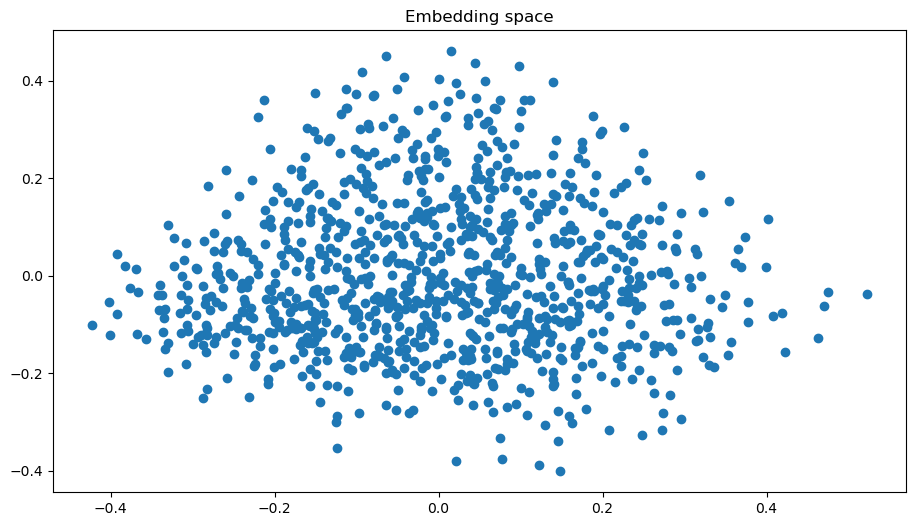

In [5]:
pca = PCA(n_components=2)
emb_2d = pca.fit_transform(embeddings)

plt.figure(figsize=(11, 6))
plt.title('Embedding space')
plt.scatter(emb_2d[:, 0], emb_2d[:, 1])
plt.show()

## Nearest Neighbors
- We use the NearestNeighbors algorithm to find the closest movies in the embedding space.

In [6]:
nn = NearestNeighbors(n_neighbors=10)
nn.fit(embeddings)

NearestNeighbors(n_neighbors=10)

## Recommend Function
- We define the recommend() function that takes a text input, finds the closest movies based on their embeddings, and returns the titles of the recommended movies.

In [7]:
def recommend(text):
    emb = embed([text])
    neighbors = nn.kneighbors(emb, return_distance=False)[0]
    return df['title'].iloc[neighbors].tolist()

print('Recommended Movies:')
recommend("After the devastating events of Avengers: Infinity War (2018), the universe is in ruins. With the help of remaining allies, the Avengers assemble once more in order to reverse Thanos' actions and restore balance to the universe.")

Recommended Movies:


['Avengers: Endgame',
 'Avengers: Infinity War',
 'Thor: Ragnarok',
 'Avengers: Age of Ultron',
 'Spider-Man: Far from Home',
 'The Avengers',
 'Captain Marvel',
 'Captain America: Civil War',
 'Thor: The Dark World',
 'Fantastic Four: Rise of the Silver Surfer']

# Version 2: Movie Recommender several parameters.

In [8]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

### Loading our dataset and pre-processing the data

In [9]:
df = pd.read_csv("movies_cleaned.csv")
df = df[["title", "genre", "summary", "directors", "actors"]]
df['combined'] = df['title'] + ' ' + df['genre'] + ' ' + df['summary'] + ' ' + df['directors'] + ' ' + df['actors']

### Loading a pre-trained BERT model and tokenizer

In [10]:
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

C:\Users\12301\anaconda3\envs\School\lib\site-packages\huggingface_hub\file_download.py:123: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\12301\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Function to get sentence embeddings

In [11]:
def get_sentence_embeddings(sentences, tokenizer, model, max_length=512):
    inputs = tokenizer(sentences, return_tensors="pt", padding=True, truncation=True, max_length=max_length)
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1).detach().numpy()
    return embeddings

### Generate embeddings for our dataset:

In [ ]:
sentences = df['combined'].tolist()
embeddings = get_sentence_embeddings(sentences, tokenizer, model)

### nearest neighbors

In [ ]:
nn = NearestNeighbors(n_neighbors=10)
nn.fit(embeddings)

### Recommendation function

In [ ]:
def recommend(text, tokenizer, model, nn, df):
    emb = get_sentence_embeddings([text], tokenizer, model)
    neighbors = nn.kneighbors(emb, return_distance=False)[0]
    return df['title'].iloc[neighbors].tolist()

In [ ]:
input_text = "After the devastating events of Avengers: Infinity War (2018), the universe is in ruins. With the help of remaining allies, the Avengers assemble once more in order to reverse Thanos' actions and restore balance to the universe."
print('Recommended Movies:')
print(recommend(input_text, tokenizer, model, nn, df))

### Saving our model

In [ ]:
# model.save_pretrained("movie_recommender_model")
# tokenizer.save_pretrained("movie_recommender_tokenizer")

### Load our model

In [ ]:
# model = AutoModel.from_pretrained("movie_recommender_model")
# tokenizer = AutoTokenizer.from_pretrained("movie_recommender_tokenizer")